# **Customer Segmentation for More Effective Retargeting Campaign**
Created by : **Lana Fuadi**
<br>LinkedIn   : https://www.linkedin.com/in/lanafuadi/
<br>GitHub : https://github.com/lanafuadi

### BACKGROUND

Marketing Team of Kalbe Nutritionals is currently facing dinamic challenges. As a Data Science intern, we got project to help Marketing Team to overcome these challenges. The goal of this clustering project is to optimize marketing efforts and enhance customer targeting by identifying distinct customer segments with similar characteristics and behaviors. Our metric is the segments of customers that allows marketers to create personalized campaign based on it. Our objective is to group customers based on their preferences, needs, and engagement patterns to create more targeted and personalized marketing campaigns.

## LOAD DATASET

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)

In [3]:
dataset = pd.read_csv('dataset.csv')

In [4]:
data = dataset.copy()

## DATA PREPARATION

In [246]:
info_data = pd.DataFrame({'Missing Values' : data.isnull().sum(),
                          '% Missing'      : round(data.isnull().mean()*100),
                          'Unique Values'  : data.nunique(),
                          'Data Type'      : data.dtypes})
info_data = info_data.sort_values(by='Missing Values', ascending=False)
info      = info_data.reset_index(names='Feature')
info

,Feature,Missing Values,% Missing,Unique Values,Data Type
0,Marital Status,44,1.0,2,object
1,customerid,0,0.0,447,int64
2,totalamount,0,0.0,44,int64
3,longitude,0,0.0,14,object
4,latitude,0,0.0,14,object
5,Type,0,0.0,2,object
6,groupstore,0,0.0,7,object
7,storename,0,0.0,12,object
8,storeid,0,0.0,14,int64
9,qty,0,0.0,10,int64


## DATA PRE-PROCESSING

### Handle Missing Values

In [247]:
info_data    = pd.DataFrame({'Missing Values' : data.isnull().sum(),
                             '% Missing'      : round(data.isnull().mean()*100),
                             'Unique Values'  : data.nunique(),
                             'Data Type'      : data.dtypes})
info_data    = info_data.sort_values(by='Missing Values', ascending=False)
missing_data = info_data[info_data['Missing Values']>0]
missing_data = missing_data.reset_index(names='Feature')
missing_data

,Feature,Missing Values,% Missing,Unique Values,Data Type
0,Marital Status,44,1.0,2,object


In [5]:
# Fill the missing values from Marital Status with the mode
data['Marital Status'].fillna(data['Marital Status'].mode().iloc[0], inplace=True)

In [6]:
data.isna().sum().sum()

0

### Drop Unnecesary Features

In [7]:
# We will drop unnecesary features like 'customerid', 'Date', 'transactionid','Product Name', 'storename', 'groupstore', 'latitude', 'longitude'
data.drop(['customerid', 'Date', 'transactionid','Product Name', 'storename', 'groupstore', 'latitude', 'longitude'], axis=1, inplace=True)

* customerid serves as an identifier rather than a feature describing customer behavior.
* Date represents the date of each transaction, the temporal aspect of customer behavior may not relevant.
* transactionid is similar to customerid, contains unique identifier for each transaction and does not carry information about customer behavior.
* Product Name, storename, and groupstore will be drop because we have productid and storeid, which are more convenience for machine learning.
* latitude and longitude contains geographical coordinates may not be relevant for customer segmentation.

In [8]:
data.shape

(5020, 10)

### Handle Duplicate Values

In [9]:
data.duplicated().sum()

50

We have 5020 data, 50 duplicate values is considerable not significant. we will drop it.

In [10]:
data.drop_duplicates(inplace=True)

In [11]:
data.duplicated().sum()

0

### Feature Encoding

In [12]:
data.dtypes

age                int64
gender             int64
Marital Status    object
income            object
productid         object
price              int64
qty                int64
totalamount        int64
storeid            int64
Type              object
dtype: object

In [13]:
data.sample(5)

,age,gender,Marital Status,income,productid,price,qty,totalamount,storeid,Type
2043,32,0,Married,"7,36",P2,3200,6,19200,11,General Trade
1276,33,0,Married,"10,9",P9,10000,6,60000,6,Modern Trade
1383,38,0,Single,"7,95",P9,10000,2,20000,5,General Trade
440,55,1,Married,"14,59",P5,4200,2,8400,11,General Trade
2550,44,1,Married,"9,57",P9,10000,5,50000,8,General Trade


In [14]:
data['Marital Status'] = data['Marital Status'].apply(lambda x: 1 if x == 'Married' else 0)
data['Type']           = data['Type'].apply(lambda x: 1 if x == 'Modern Trade' else 0)
data['productid']      = data['productid'].apply(lambda x: int(x.replace('P', '')))
data['income']         = data['income'].str.replace(',', '.').astype(float)

In [15]:
data.dtypes

age                 int64
gender              int64
Marital Status      int64
income            float64
productid           int64
price               int64
qty                 int64
totalamount         int64
storeid             int64
Type                int64
dtype: object

### Handle Outlier

In [16]:
data.columns

Index(['age', 'gender', 'Marital Status', 'income', 'productid', 'price',
       'qty', 'totalamount', 'storeid', 'Type'],
      dtype='object')

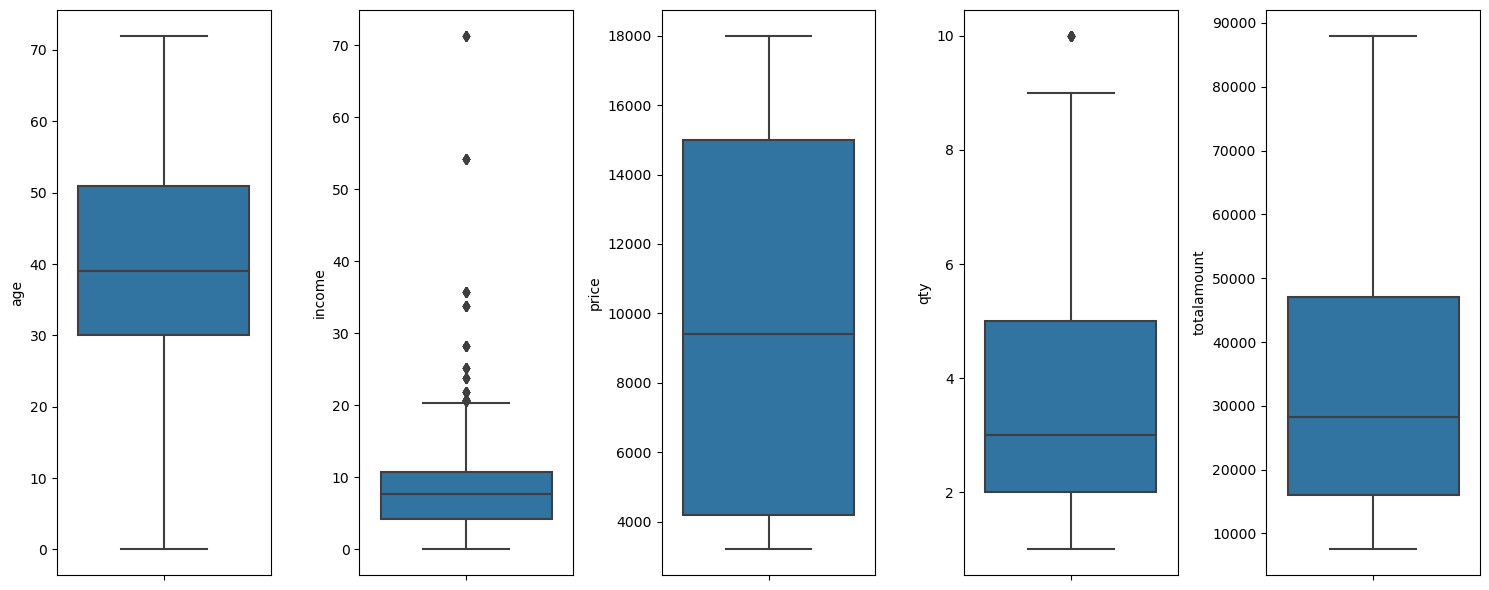

In [17]:
num = ['age', 'income', 'price', 'qty', 'totalamount']
plt.figure(figsize=(15, 6))
for i in range(0, len(num)):
    plt.subplot(1, 5, i+1)
    sns.boxplot(y=data[num[i]])
    plt.tight_layout()

* Features income and qty have outlier.

In [18]:
print(f'Before handling outlier we have {len(data)} rows')

# Menghitung Q1, Q3, dan IQR
Q1 = data[num].quantile(0.25)
Q3 = data[num].quantile(0.75)
IQR = Q3 - Q1

# Menentukan batas bawah dan batas atas
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Membuat mask untuk menghilangkan outlier
mask = ((data[num] >= lower_bound) &
        (data[num] <= upper_bound)).all(axis = 1)
data = data[mask].reset_index(drop = True)

print(f'After handling outlier we have {len(data)} rows')

Before handling outlier we have 4970 rows
After handling outlier we have 4805 rows


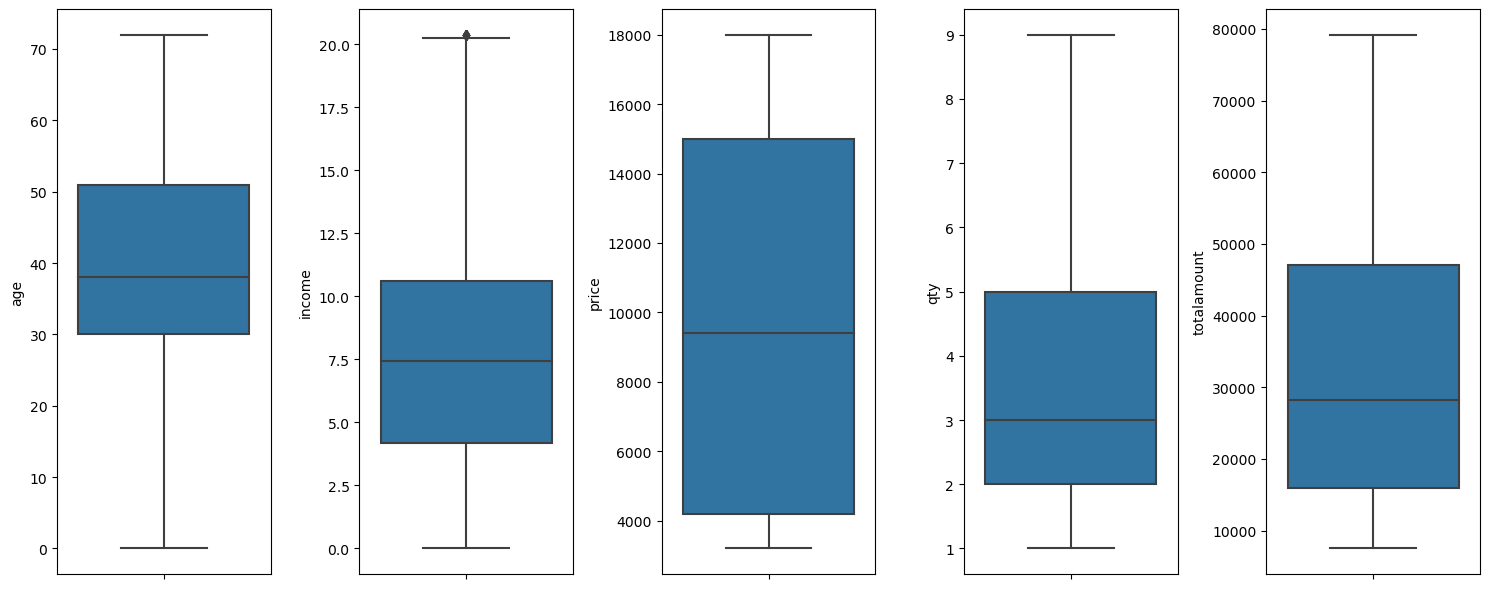

In [19]:
num = ['age', 'income', 'price', 'qty', 'totalamount']
plt.figure(figsize=(15, 6))
for i in range(0, len(num)):
    plt.subplot(1, 5, i+1)
    sns.boxplot(y=data[num[i]])
    plt.tight_layout()

### Handle Skewness

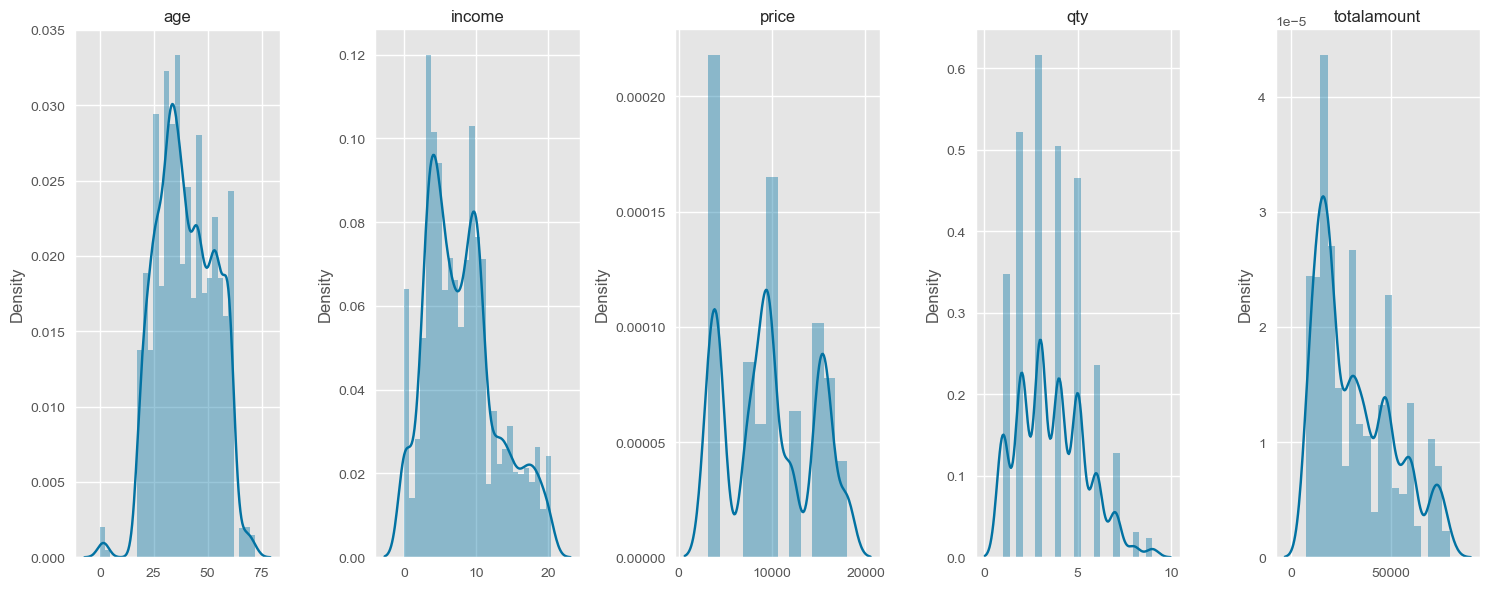

In [313]:
plt.figure(figsize=(15, 6))
for x in range(0, len(num)):
    plt.subplot(1, 5, x+1)
    sns.distplot(data[num[x]], color='b')
    plt.title(num[x], fontsize=12)
    plt.xlabel('')
    plt.tight_layout()

In [20]:
num      = ['age', 'income', 'price', 'qty', 'totalamount']
skewness = data[num].skew()
result   = pd.concat([pd.DataFrame({'Feature': skewness.index}), pd.DataFrame({'Skewness': skewness.values})], axis=1)
result   = result.sort_values(by='Skewness', ascending=False)
print(result)

       Feature  Skewness
4  totalamount  0.722607
1       income  0.582908
3          qty  0.466229
2        price  0.161659
0          age  0.056521


we will not handle skewness because the are still in the acceptable skewness range (between 0 to 1).

### Scaling

In [24]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
age,4805.0,39.789594,12.859423,0.0,30.00,38.00,51.00,72.00
gender,4805.0,0.450780,0.497623,0.0,0.00,0.00,1.00,1.00
Marital Status,4805.0,0.764828,0.424150,0.0,1.00,1.00,1.00,1.00
income,4805.0,8.019234,4.877366,0.0,4.17,7.44,10.62,20.37
productid,4805.0,5.679292,2.859490,1.0,3.00,5.00,8.00,10.00
price,4805.0,9697.252862,4616.907794,3200.0,4200.00,9400.00,15000.00,18000.00
qty,4805.0,3.601665,1.770302,1.0,2.00,3.00,5.00,9.00
totalamount,4805.0,31921.498439,19101.998498,7500.0,16000.00,28200.00,47000.00,79200.00
storeid,4805.0,7.493652,4.031543,1.0,4.00,7.00,11.00,14.00
Type,4805.0,0.430177,0.495152,0.0,0.00,0.00,1.00,1.00


* There are some abnormal value in the data.
* Features age and income has minimum value 0.
* We will change 0 value from age to be 18, a legal age in Indonesia.
* While 0 value in income is acceptable in the context of monthly income and many Indonesian citizen do not have any income.

In [25]:
data.loc[data['age'] < 18, 'age'] = 18

Then we will scale features price and totalamount

In [26]:
from sklearn.preprocessing import MinMaxScaler

features_to_scale       = ['price', 'totalamount']
scaler                  = MinMaxScaler()
data[features_to_scale] = scaler.fit_transform(data[features_to_scale])

In [27]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
age,4805.0,39.891988,12.617598,18.0,30.000000,38.000000,51.000000,72.00
gender,4805.0,0.450780,0.497623,0.0,0.000000,0.000000,1.000000,1.00
Marital Status,4805.0,0.764828,0.424150,0.0,1.000000,1.000000,1.000000,1.00
income,4805.0,8.019234,4.877366,0.0,4.170000,7.440000,10.620000,20.37
productid,4805.0,5.679292,2.859490,1.0,3.000000,5.000000,8.000000,10.00
price,4805.0,0.439004,0.311953,0.0,0.067568,0.418919,0.797297,1.00
qty,4805.0,3.601665,1.770302,1.0,2.000000,3.000000,5.000000,9.00
totalamount,4805.0,0.340607,0.266416,0.0,0.118550,0.288703,0.550907,1.00
storeid,4805.0,7.493652,4.031543,1.0,4.000000,7.000000,11.000000,14.00
Type,4805.0,0.430177,0.495152,0.0,0.000000,0.000000,1.000000,1.00


## MODELING

In [47]:
datamod = data.copy()

### PCA

In [29]:
from sklearn.decomposition import PCA

pca   = PCA(n_components = 4)
pca.fit(datamod)
pcatf = pca.transform(datamod)
pcadf = pd.DataFrame(pcatf, columns = ['pc1', 'pc2', 'pc3', 'pc4'])
pcadf.describe()

,pc1,pc2,pc3,pc4
count,4.805000e+03,4.805000e+03,4.805000e+03,4.805000e+03
mean,-1.750848e-15,8.281039e-17,9.700646e-16,2.957514e-16
std,1.293231e+01,4.042015e+00,3.972505e+00,2.940864e+00
min,-2.317701e+01,-8.300153e+00,-1.113043e+01,-5.431032e+00
25%,-1.051373e+01,-3.433675e+00,-2.695883e+00,-2.619341e+00
50%,-1.408681e+00,1.583458e-02,-3.664265e-01,2.185454e-01
75%,1.207981e+01,3.520627e+00,2.498914e+00,2.276304e+00
max,3.051220e+01,8.529033e+00,1.207254e+01,6.434418e+00


### Scree Plot

Explained variance: [167.2445181   16.33788743  15.78079684   8.64867886]
Explained variance ratio: [0.79113776 0.07728516 0.07464989 0.04091193]


<BarContainer object of 4 artists>

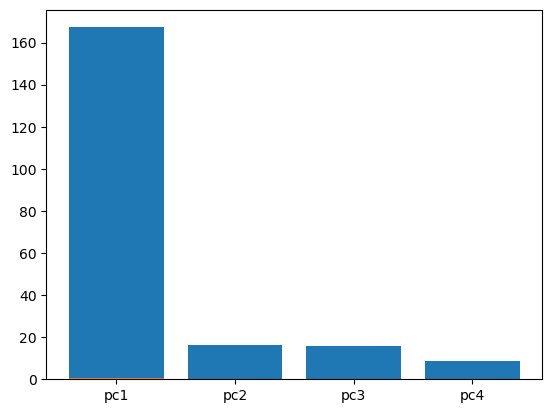

In [30]:
print('Explained variance:', pca.explained_variance_)
print('Explained variance ratio:', pca.explained_variance_ratio_)

plt.bar(['pc1', 'pc2', 'pc3', 'pc4'], pca.explained_variance_)
plt.bar(['pc1', 'pc2', 'pc3', 'pc4'], pca.explained_variance_ratio_)

### Pair Plot

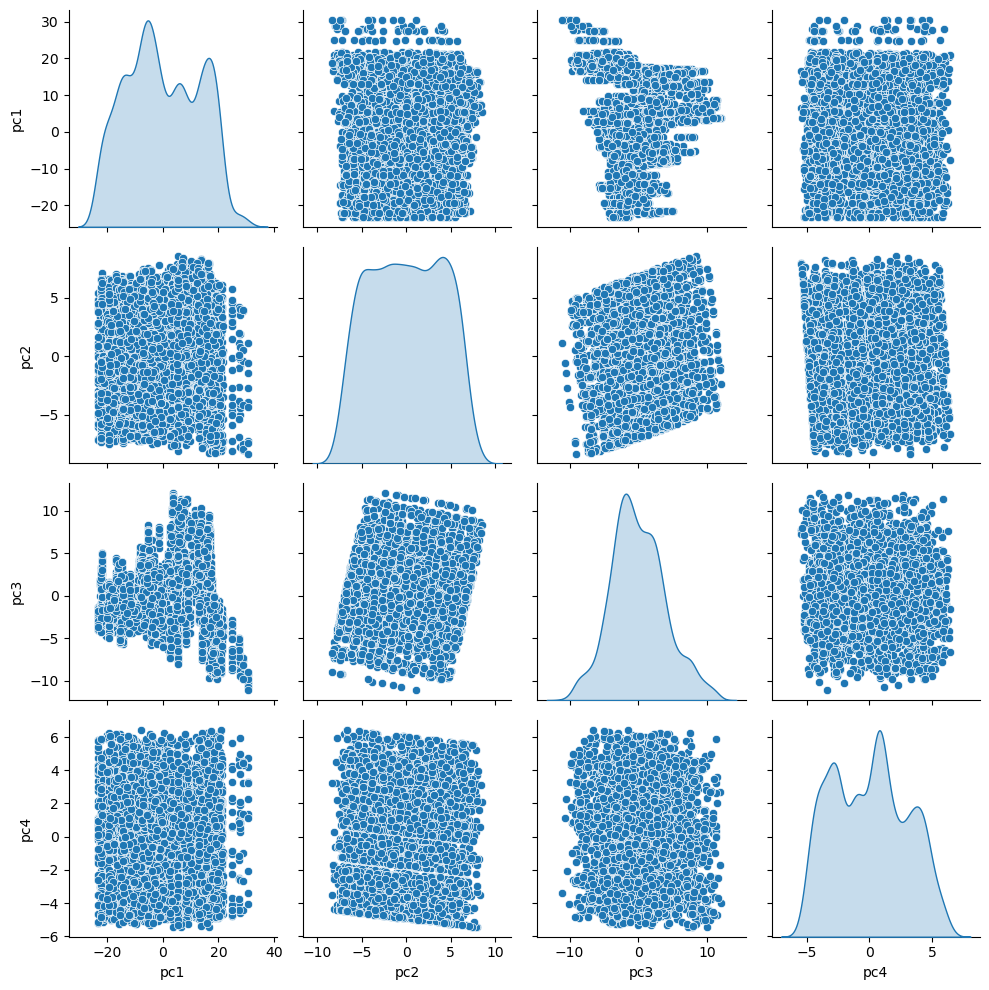

In [31]:
sns.pairplot(pcadf, diag_kind = 'kde')
plt.tight_layout()

### Inertia Elbow  Plot

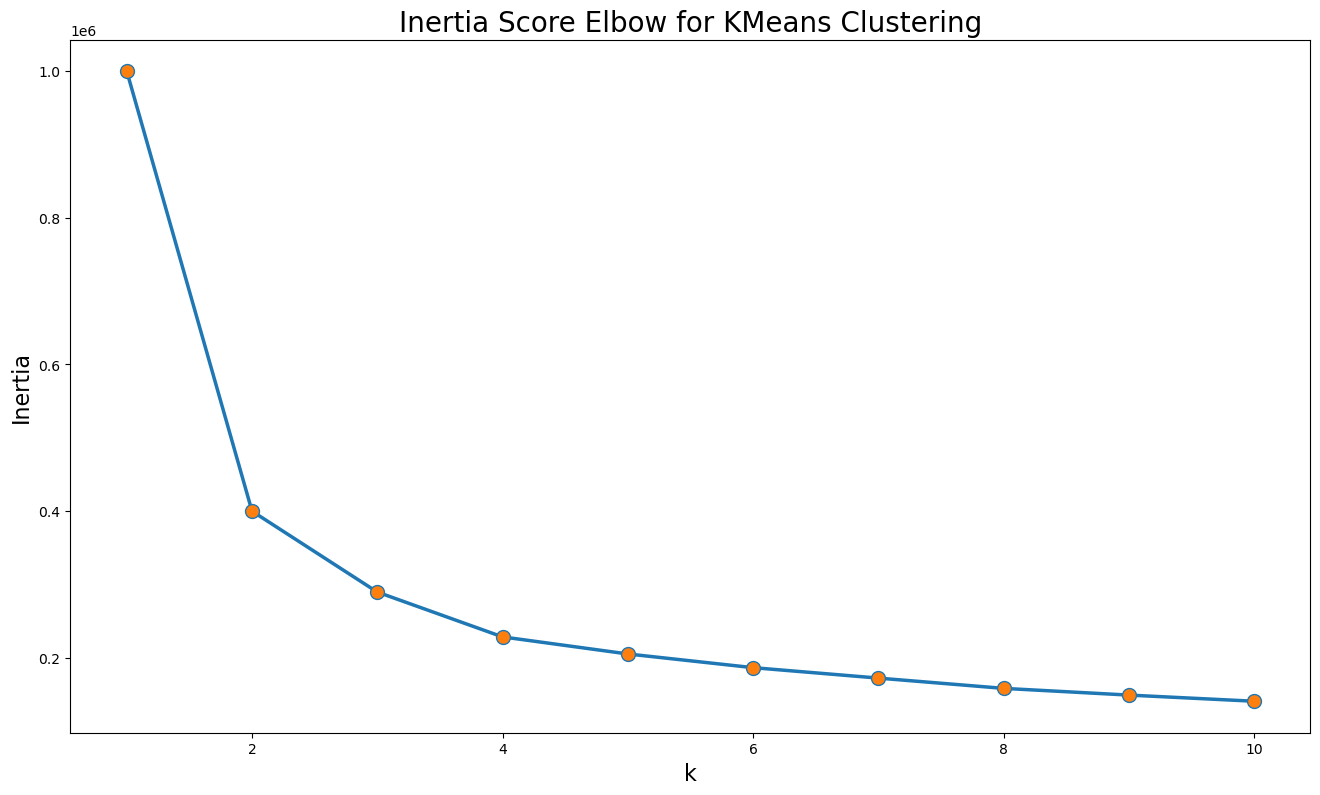

In [32]:
from sklearn.cluster import KMeans

inertia = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', n_init=10,
                    max_iter=200, random_state=100)
    kmeans.fit(pcadf)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(16, 9))
plt.plot(range(1, 11),
         inertia,
         color='tab:blue',
         linewidth=2.5,
         marker='o',
         markerfacecolor='tab:orange',
         markersize=10)
plt.xlabel('k', fontsize=16)
plt.ylabel('Inertia', fontsize=16)
plt.style.use('ggplot')
plt.title('Inertia Score Elbow for KMeans Clustering', fontsize=20)
plt.show()

We can see that after 4, there is no significant change.

In [33]:
(pd.Series(inertia) - pd.Series(inertia).shift(-1)) / pd.Series(inertia) * 100

0    59.951928
1    27.523862
2    21.051819
3    10.151379
4     9.060465
5     7.598420
6     8.089074
7     5.761852
8     5.581843
9          NaN
dtype: float64

It appears that the inertia values decrease rapidly until 3 clusters and then start to level off.

### Distortion Score Elbow

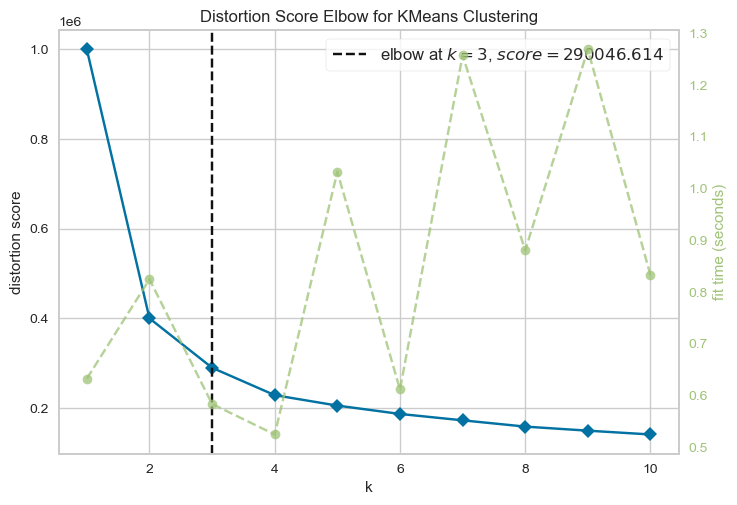

<AxesSubplot: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [34]:
from yellowbrick.cluster import KElbowVisualizer

model      = KMeans(init = 'k-means++', n_init = 10, max_iter = 200, random_state = 400)
visualizer = KElbowVisualizer(model, k = (1, 11), metric = 'distortion', timings = True, locate_elbow = True)
visualizer.fit(pcadf)
visualizer.show()

The best cluster based on distortion score is 3.

### Silhouette Score Elbow

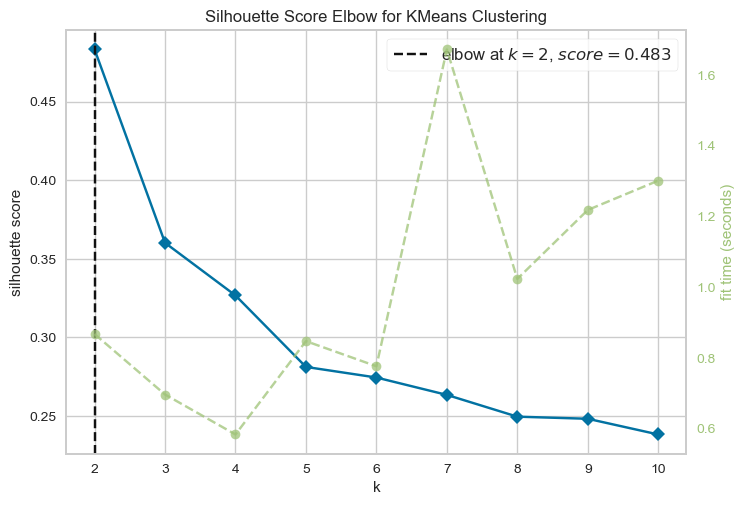

<AxesSubplot: title={'center': 'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [35]:
from yellowbrick.cluster import KElbowVisualizer

model = KMeans(init = 'k-means++', n_init = 10, max_iter = 200, random_state = 400)
visualizer = KElbowVisualizer(model, k = (2, 11), metric = 'silhouette', timings = True, locate_elbow = True)
visualizer.fit(pcadf)
visualizer.show()

### Silhouette Coefficient Plot

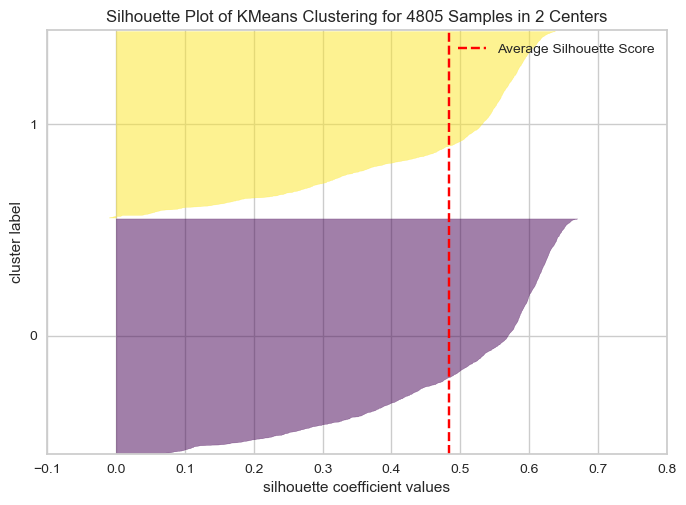

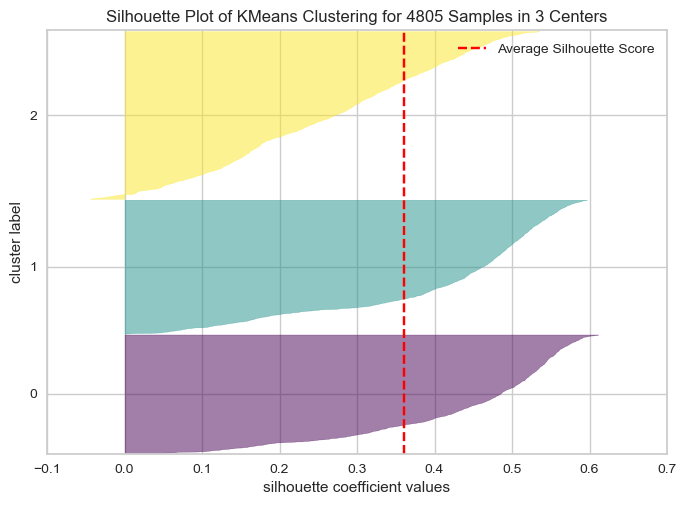

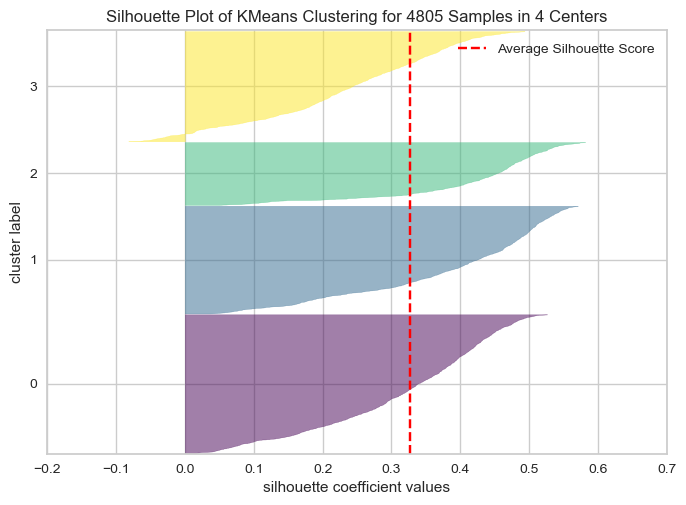

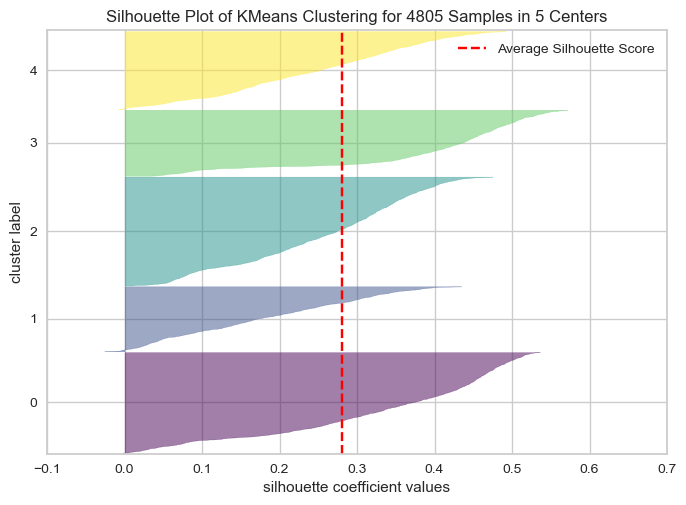

In [36]:
from yellowbrick.cluster import SilhouetteVisualizer

for i in [2, 3, 4, 5]:
    model = KMeans(i, init = 'k-means++', n_init = 10, max_iter = 200, random_state = 400)
    visualizer = SilhouetteVisualizer(model, colors = 'viridis')
    visualizer.fit(pcadf)        
    visualizer.show()

### Silhouette Score Plot

In [37]:
from sklearn.metrics import silhouette_score

def visualize_silhouette_layer(data):
    clusters_range = range(2, 10)
    results = []

    for i in clusters_range:
        km = KMeans(n_clusters=i, random_state=100)
        cluster_labels = km.fit_predict(data)
        silhouette_avg = silhouette_score(data, cluster_labels)
        results.append([i, silhouette_avg])

    result = pd.DataFrame(results, columns=['n_clusters', 'silhouette_score'])
    pivot_km = pd.pivot_table(result, index='n_clusters', values='silhouette_score')

    plt.figure(figsize=(8, 9))
    sns.heatmap(pivot_km, annot=True, linewidths=1, fmt='.3f', cmap='viridis')
    plt.tight_layout()
    plt.title('Silhouette Score of K-means Clustering', fontsize=20, fontweight='bold')
    plt.show()

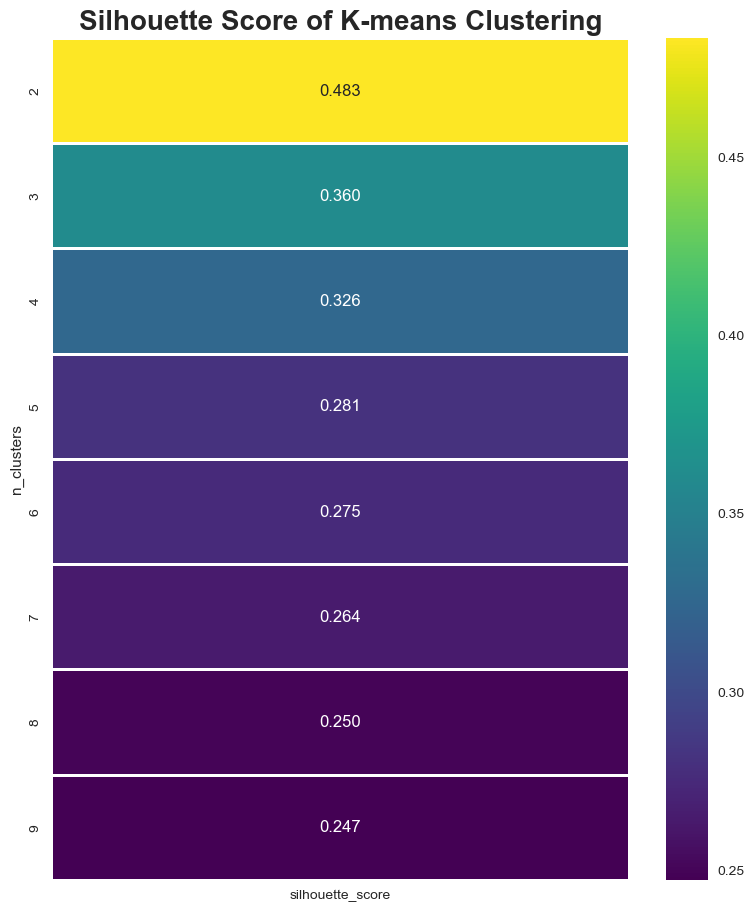

In [38]:
visualize_silhouette_layer(pcadf)

2 is the best k according to silhouette coefficient values, but it is too few for our customer segmentation. thus, we prefer to 3 since it is the 2nd best k.

### Fit The Model

In [48]:
from sklearn.cluster import KMeans

km = KMeans(n_clusters=3,
            init='k-means++',
            n_init=10,
            max_iter=200,
            random_state=100)
km.fit(datamod.values)

KMeans(max_iter=200, n_clusters=3, n_init=10, random_state=100)

### Group By on Cluster

In [49]:
# Labels
datamod['cluster'] = km.labels_
datamod.groupby('cluster').agg(['std', 'mean', 'median'])

age                      gender                  Marital Status  \
              std       mean median       std      mean median            std   
cluster                                                                         
0        4.545978  38.294578   38.0  0.492581  0.413452    0.0       0.333884   
1        5.200443  55.104439   55.0  0.498246  0.456266    0.0       0.254966   
2        4.029624  24.953506   25.0  0.500178  0.497417    0.0       0.494651   

                            income                   productid            \
             mean median       std       mean median       std      mean   
cluster                                                                    
0        0.872263    1.0  4.078005   8.799698   8.82  2.820468  5.698644   
1        0.930157    1.0  4.409146  11.225235  10.68  2.872671  5.627285   
2        0.425830    0.0  1.999488   3.289697   3.43  2.900440  5.710701   

                   price                           qty                   \
        median       std      mean    median       std      mean median   
cluster                                                                   
0          5.0  0.310422  0.434335  0.418919  1.762700  3.646507    3.0   
1          5.0  0.316832  0.448336  0.418919  1.781076  3.514360    3.0   
2          5.0  0.308536  0.435060  0.418919  1.766535  3.636900    3.0   

        totalamount                       storeid                       Type  \
                std      mean    median       std      mean median       std   
cluster                                                                        
0          0.264380  0.343638  0.288703  4.015322  7.493743    7.0  0.494220   
1          0.268959  0.334489  0.263598  3.986330  7.436684    7.0  0.494884   
2          0.266477  0.343233  0.313808  4.106611  7.557934    8.0  0.496901   

                          
             mean median  
cluster                   
0        0.423358    0.0  
1        0.427546    0.0  
2        0.442804    0.0

In [50]:
datamod.groupby('cluster').count()

,age,gender,Marital Status,income,productid,price,qty,totalamount,storeid,Type
cluster,,,,,,,,,,
0,1918,1918,1918,1918,1918,1918,1918,1918,1918,1918
1,1532,1532,1532,1532,1532,1532,1532,1532,1532,1532
2,1355,1355,1355,1355,1355,1355,1355,1355,1355,1355


### Customer Segmentation

In [51]:
km.cluster_centers_

array([[38.29457769,  0.41345151,  0.87226277,  8.7996976 ,  5.69864442,
         0.43433475,  3.64650678,  0.34363797,  7.49374348,  0.42335766],
       [55.10443864,  0.45626632,  0.93015666, 11.22523499,  5.6272846 ,
         0.44833639,  3.51436031,  0.3344886 ,  7.43668407,  0.42754569],
       [24.95350554,  0.49741697,  0.42583026,  3.28969742,  5.71070111,
         0.43506034,  3.63690037,  0.34323313,  7.55793358,  0.44280443]])

In [52]:
from sklearn.decomposition import PCA 
pca = PCA(n_components=4)

pca.fit(datamod)
pcatf            = pca.transform(datamod)
pcadf            = pd.DataFrame(data=pcatf, columns=['pc1', 'pc2', 'pca3', 'pca4'])
pcadf['cluster'] = datamod['cluster']
pcadf.sample(n=5, random_state=100)

,pc1,pc2,pca3,pca4,cluster
1260,4.999577,-6.824453,0.309777,-3.364826,0
2482,19.584910,2.450286,-9.627883,-1.002908,1
2401,-7.154764,-0.715506,4.201725,-1.401893,0
959,18.121945,-6.000818,-0.859757,-2.984280,1
3327,-1.369457,5.298638,1.428714,5.650442,0


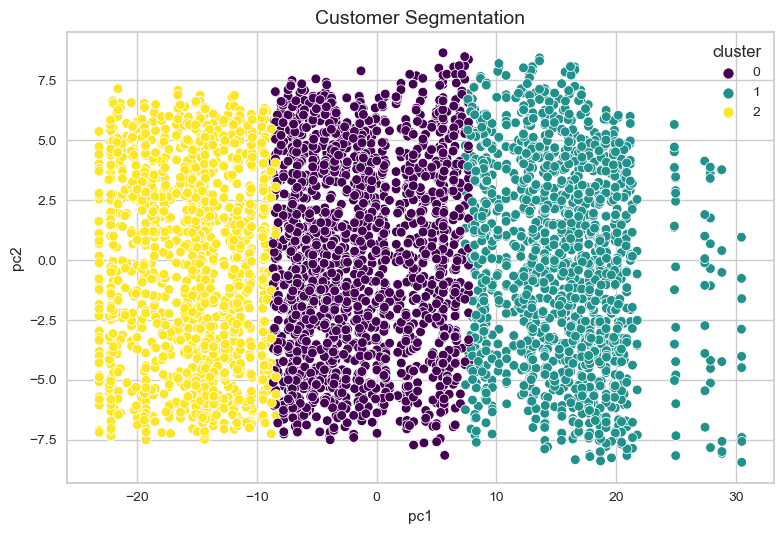

In [54]:
sns.scatterplot(data=pcadf,
                x='pc1',
                y='pc2',
                hue='cluster',
                palette='viridis')
plt.title('Customer Segmentation', fontsize=14)
plt.tight_layout()
plt.show()

### Segment Visualization

In [75]:
datanew            = data.copy()
datanew['cluster'] = km.labels_

In [76]:
datanew.head()

,age,gender,Marital Status,income,productid,price,qty,totalamount,storeid,Type,cluster
0,36,0,1,10.53,3,0.290541,4,0.313808,12,0,0
1,44,1,1,14.58,9,0.459459,7,0.871688,1,1,0
2,27,1,0,0.18,1,0.378378,4,0.386332,4,0,2
3,48,1,1,12.57,1,0.378378,7,0.754533,4,0,1
4,33,0,1,6.95,9,0.459459,1,0.034868,4,0,0


In [90]:
features     = ['age', 'Marital Status', 'income', 'price', 'qty', 'totalamount', 'cluster']
data_summary = datanew[features]
summary      = round(data_summary.groupby('cluster').agg(['median']), 2)
summary

,age,Marital Status,income,price,qty,totalamount
,median,median,median,median,median,median
cluster,,,,,,
0,38.0,1.0,8.82,0.42,3.0,0.29
1,55.0,1.0,10.68,0.42,3.0,0.26
2,25.0,0.0,3.43,0.42,3.0,0.31


In [91]:
cluster_percent               = data_summary['cluster'].value_counts().reset_index()
cluster_percent.columns       = ['cluster', 'count']
cluster_percent['percentage'] = round((cluster_percent['count'] / len(data_summary)) * 100, 2)
cluster_percent               = cluster_percent.sort_values(by=['cluster']).reset_index(drop=True)
cluster_percent

,cluster,count,percentage
0,0,1918,39.92
1,1,1532,31.88
2,2,1355,28.20


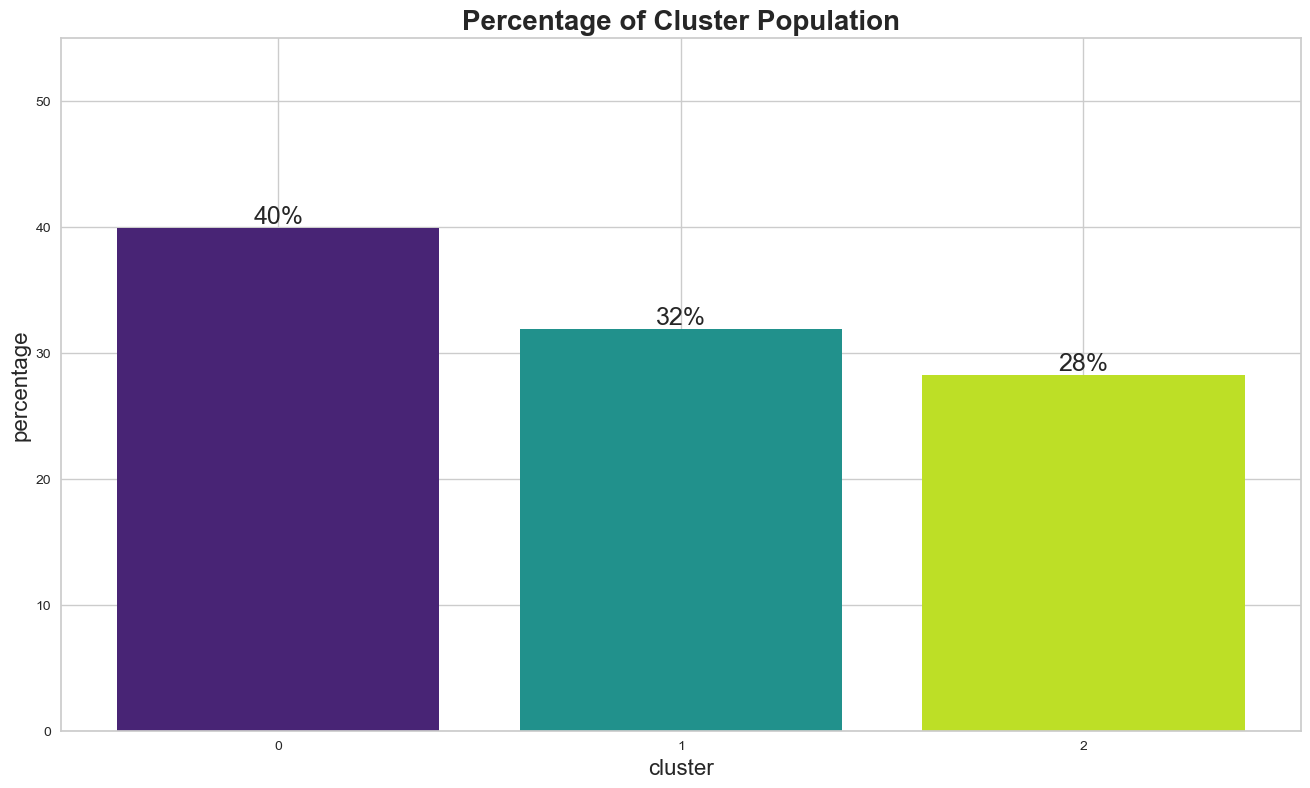

In [79]:
fig, ax = plt.subplots(figsize=(16, 9))
bars = plt.bar(x=cluster_percent['cluster'], height=cluster_percent['percentage'], color=colors)

plt.title('Percentage of Cluster Population', fontsize=20, fontweight='bold')
plt.bar_label(ax.containers[0], fmt='%.0f%%', fontsize=18)
plt.xlabel('cluster', fontsize=16)
plt.xticks(range(0, 3))
plt.ylabel('percentage', fontsize=16)
plt.ylim(0, 55)
plt.show()

Cluster Distribution: Cluster 0 has the highest count with 1918 data points (39.92%), followed by Cluster 1 with 1532 data points (31.88%), and Cluster 2 with 1355 data points (28.20%).

In [80]:
colors = plt.cm.viridis([0.1, 0.5, 0.9])

In [92]:
""" def dist_list(list):
    plt.figure(figsize=[16, 9])
    i = 1
    for col in list:
        ax = plt.subplot(2, 3, i)
        ax.vlines(data[col].median(), ymin=-0.5, ymax=2.5, color='black', linestyle='--')
        g = datanew.groupby('cluster')
        x = g[col].median().index
        y = g[col].median().values
        ax.barh(x, y, color=colors) 
        plt.title(col)
        plt.ylabel('cluster')
        ax.yaxis.set_major_locator(plt.MaxNLocator(integer=True))
        i = i + 1 """

" def dist_list(list):\n    plt.figure(figsize=[16, 9])\n    i = 1\n    for col in list:\n        ax = plt.subplot(2, 3, i)\n        ax.vlines(data[col].median(), ymin=-0.5, ymax=2.5, color='black', linestyle='--')\n        g = datanew.groupby('cluster')\n        x = g[col].median().index\n        y = g[col].median().values\n        ax.barh(x, y, color=colors) \n        plt.title(col)\n        plt.ylabel('cluster')\n        ax.yaxis.set_major_locator(plt.MaxNLocator(integer=True))\n        i = i + 1 "

In [93]:
""" dist_list(['age', 'Marital Status', 'income', 'price', 'qty', 'totalamount'])
plt.tight_layout(pad=5)
plt.show() """

" dist_list(['age', 'Marital Status', 'income', 'price', 'qty', 'totalamount'])\nplt.tight_layout(pad=5)\nplt.show() "

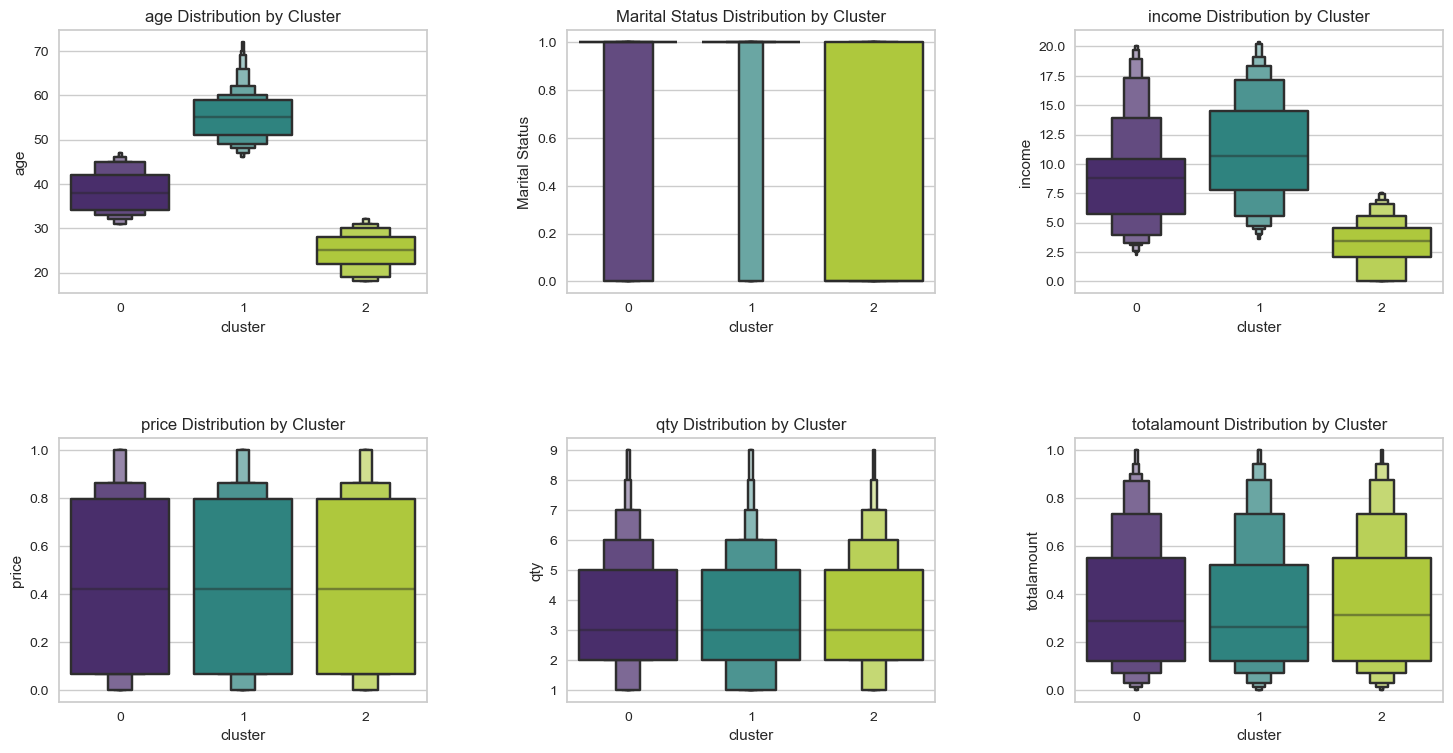

In [84]:
features = ['age', 'Marital Status', 'income', 'price', 'qty', 'totalamount']
plt.figure(figsize=(16, 9))
for i in range(0, len(features)):
    plt.subplot(2, 3, i+1)
    sns.boxenplot(x='cluster', y=data[features[i]], data=datanew, palette=colors).set(title=f'{features[i]} Distribution by Cluster')
    plt.tight_layout(pad=5)
plt.show()

## **BUSINESS RECOMMENDATION**

**General Recommendation**
<br>1. Collaborate with healthcare providers, hospitals, and pharmacies to expand the reach and distribution of Kalbe Nutritionals's products.
<br>2. Implement strict quatlity control to ensure the effectiveness of all products and to maintain customer's loyalty.
<br>3. Initiate a routine Corporate Social Responsibily (CSR) programthat promote access to healthcare and well-being of communities. this way, Kalbe will be well recognized, trusted, and increase customer engagement.

<br>**Cluster 0 Recommendation**
<br>1. Conduct targeted marketing campaigns focusing on customers age around 38 years and income around 8 millions. Tailor the campaign to emphasize the benefits of pharmaceutical products in maintaining health and vitality during this stage of life.
<br>2. Conduct special program for this segment, such as 'Fit Forthy' membership with benefit of personalized product and activities for member.
<br>3. Implement loyalty program for this segment to encourage repear purchases and foster brand loyalty. offer reward, discount, or exclusive offers for customer who reach some stage or point.

<br>**Cluster 1 Recommendation**
<br>1. This segment is of older customers with age around 55 and income around 11 millions. as the highest income customers segment, cluster 1 is the less contribute on our revenue. this means our campaign for this segemnet is not effective. personalized retargeting campaign is a must.
<br>2. Offer special program for this segment, such as 'Golden 50' membership with benefit customized based on this segment. including telehealth service or health delivery to be one step ahead of our competitiors.
<br>3. Older customers often prioritize convenience service and big brand when choosing anything related to their health. increase brand awareness by conducting various seminar related to elderly well-being and collaborate with public figure.
<br> Focus the campaign on supplements that support healthy aging and adress age-related health issues like joint healh, memory, and cardiovascular health.

<br>**Cluster 2 Recommendation**
<br>1. This segment consist of younger customers with age around 25 and income around 3 millions, but gave most contribution on our reveneu.
<br>2. Attract younger customers with as sports, healthkathon, and other health competition program.
<br>3. Introduce customized membership program for this segment, including psycho-session where they will get benefit related to stress and quarter life crisis.
<br>4. Provide affordable price for this segment, like student special treatment and so on.